### Attacking VGG trained on CIFAR10

In this notebook we aim to perform an adversarial attack against a black-box model trained on *Cifar10* 

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
cd /content/gdrive/My Drive/Colab Notebooks/AdvAttack

/content/gdrive/My Drive/Colab Notebooks/AdvAttack


**Import packages**

In [0]:
import src.loss as customLoss
import src.ZOOptim as ZOOptim
import src.dataset as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
from torch import nn, optim
from torchvision import transforms
from src.models import MyVGG

**Retrieve CIFAR10 data**

We retrieve the CIFAR10 data. <br>
We use the *standard* option to retrieve the unnormalized and unchanged data. 

Files already downloaded and verified
Files already downloaded and verified

Batch is a <class 'list'>
The 1st element is a <class 'torch.Tensor'> with shape torch.Size([32, 3, 32, 32])
The 2nd element is a <class 'torch.Tensor'> with shape torch.Size([32])


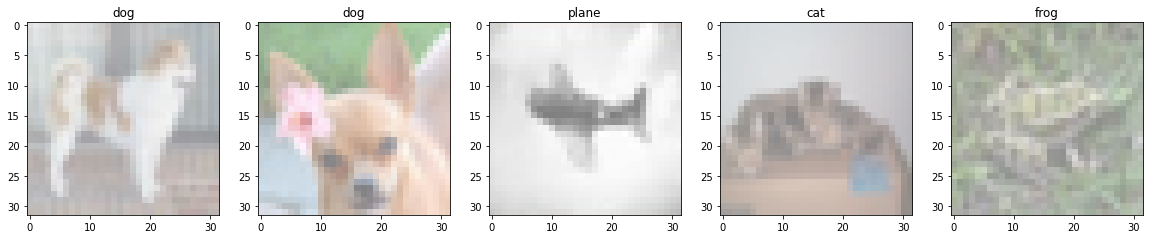

In [49]:
DataLoader = data.CIFAR10(transform='standard')
train, test = DataLoader.get_dataloader(batch_size=32, num_workers=0)
DataLoader.get_info()

In [50]:
device = torch.device('cuda')
net = MyVGG().to(device)
net.load_state_dict(torch.load('models/VGG16_cifar10_state_dict.pth'))

<All keys matched successfully>

In [52]:
for batch in test:
    X, y = batch[0].to(device), batch[1].to(device)
    
out = net(X)
y_pred = torch.argmax(out, axis=1)
match = y_pred - y.to(device)
TP = match[match == 0].shape[0]
print('Accuracy is {:.2f}'.format(TP/X.shape[0]))

Accuracy is 0.81


### MAIN
**5. ADVERSARIAL ATTACK**

Here we try to start with a random rightfully classified image from the validation set and we try to use *Zero-order Stochastic Coordinate descent with Coordinate-wise ADAM/Newton* to modify the image in order to make the network be mistaken.

We can choose whetever to use ADAM or Newton's Method by setting the solver parameter


**Args:**


    Name                    Type                Description
    x:                      (torch.tensor)      The variable of our optimization problem
    c:                      (float)             Loss weight
    learning_rate:          (float)             Learning rate
    n_gradient:             (int)               Coordinates we simultaneously optimize
    h:                      (float)             Gradient estimation accuracy O(h^2)
    beta_1:                 (float)             ADAM hyper-parameter
    beta_2:                 (float)             ADAM hyper-parameter
    solver:                 (str)               Either "ADAM" or "Newton"
    epsilon:                (float)             Avoid dividing by 0
    max_steps:              (int)               The maximum number of steps
    stop_criterion:         (boolean)           If true stop when the loss is 0
    verbose:                (int)               Display information. Default is 0
    tqdm_disable:           (bool)              Disable the tqdm bar. Default is False
    additional_out:         (bool)              Return also all the x. Default is False



**Suggested values** <br>
*ZOO: Zeroth Order Optimization Based Black-box Attacks to
Deep Neural Networks without Training Substitute Models* (Chen, Zhang et al.):

* learning_rate = 0.001 
* batch_size = 128
* h = 0.0001
* beta_1 = 0.9
* beta_2 = 0.999
* solver = "adam"
* max_iterations = 10000

All this parameters are initialized by default. 

**Display an example image** <br>

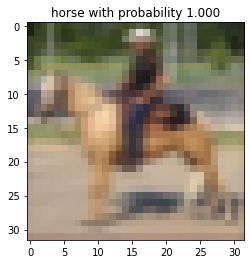

In [53]:
net.eval()
img = X[0].cpu().numpy()
out = nn.Softmax(dim=1)(net(X[0].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img, (1, 2, 0)))
original_label = torch.argmax(out).item()
plt.title('{} with probability {:.3f}'.format(DataLoader.classes[original_label], float(out[0, original_label])))
plt.show()

**5.1 General attack**

Here we try to manipulate the input such that it will be misclassified in favor of a whatever class. Usually its easier and we deal with the problem by minimizing the probability of the true class  

*E.g.* <br> 
We want to try to minimize the probability of classification of neuron *zero*

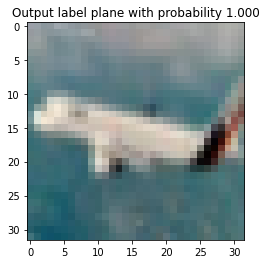

In [55]:
# 1. Choose image
index = 3

# 2. Define params
solver = "adam"
#solver = "newton"
params = {'x': X[index], 'c': 0.5, 'learning_rate': 1e-2, 
          'n_gradients': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

# 3. Display choosen image
net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig).item()
plt.title('Output "{}"({}) with probability {:.3f}'.format(DataLoader.classes[original_label], original_label,
                                                           float(out_orig[0, original_label])))
plt.show()





  0%|          | 0/1000 [00:00<?, ?it/s]



  0%|          | 1/1000 [00:00<02:15,  7.36it/s]



  0%|          | 2/1000 [00:00<02:16,  7.32it/s]



  0%|          | 3/1000 [00:00<02:14,  7.43it/s]



  0%|          | 4/1000 [00:00<02:09,  7.68it/s]



  0%|          | 5/1000 [00:00<02:04,  7.96it/s]



  1%|          | 6/1000 [00:00<02:00,  8.26it/s]



  1%|          | 7/1000 [00:00<01:56,  8.56it/s]



  1%|          | 8/1000 [00:00<01:53,  8.74it/s]



  1%|          | 9/1000 [00:01<01:51,  8.91it/s]



  1%|          | 10/1000 [00:01<01:48,  9.09it/s]



  1%|          | 11/1000 [00:01<01:47,  9.22it/s]



  1%|          | 12/1000 [00:01<01:45,  9.37it/s]



  1%|▏         | 13/1000 [00:01<01:44,  9.42it/s]



  1%|▏         | 14/1000 [00:01<01:44,  9.40it/s]



  2%|▏         | 15/1000 [00:01<01:44,  9.46it/s]



  2%|▏         | 16/1000 [00:01<01:43,  9.52it/s]



  2%|▏         | 17/1000 [00:01<01:42,  9.58it/s]



  2%|▏         | 18/1000 [00:02<01:41,  9.63it/s]



  2%|▏ 

First valid image found at iteration 47 with l2-distance = 0.1214534267783165






  5%|▌         | 51/1000 [00:05<01:32, 10.29it/s]



  5%|▌         | 53/1000 [00:05<01:31, 10.37it/s]



  6%|▌         | 55/1000 [00:05<01:31, 10.33it/s]



  6%|▌         | 57/1000 [00:05<01:31, 10.29it/s]



  6%|▌         | 59/1000 [00:06<01:31, 10.26it/s]



  6%|▌         | 61/1000 [00:06<01:31, 10.28it/s]



  6%|▋         | 63/1000 [00:06<01:31, 10.28it/s]



  6%|▋         | 65/1000 [00:06<01:31, 10.18it/s]

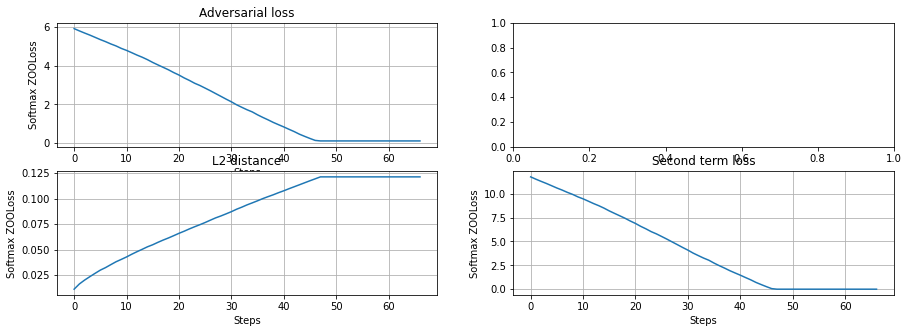

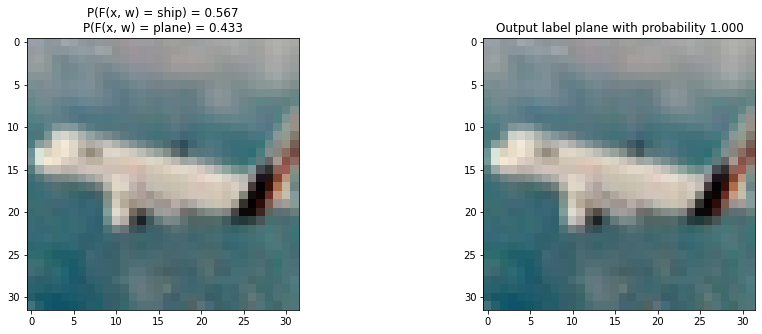

In [56]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=original_label, maximise=0, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(params)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, *list(img.shape))))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
# Adversarial Loss
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Adversarial loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
# L2 distance
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2_dist')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
# Second loss term
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

### Display adversarial example and original image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Adversarial example
ax[0].imshow(np.transpose(img_orig, (1, 2, 0)))
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], 
                                                                            float(out[0, label]),
                                                                            DataLoader.classes[original_label], 
                                                                            float(out[0, original_label])))
# Original image
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], 
                                                                 float(out_orig[0, original_label])))
plt.show()

**5.2 Specific attack**

Here we try to manipulate the input such that it will be misclassified in favor of a *specific* class.

*E.g.* <br> 
We want to try to maximise the probability of classification of neuron *three*


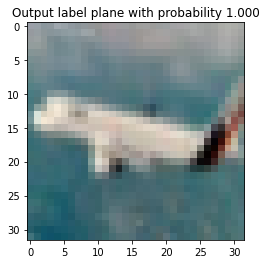

In [57]:
# 1. Choose image
index = 3

# 2. Define params
desired_ouput = 2
solver = "adam"
#solver = "newton"
params = {'x': X[index], 'c': 0.5, 'learning_rate': 1e-2, 
          'n_gradients': 128, 'solver': solver, 'max_steps': 1000, 
          'verbose': 0, 'stop_criterion': True, 'additional_out': True}

# 3. Display choosen image
net.eval()
img_orig = X[index].cpu().numpy()
out_orig = nn.Softmax(dim=1)(net(X[index].reshape(1, *list(img.shape))))
plt.imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig).item()
plt.title('Output "{}"({}) with probability {:.3f}'.format(DataLoader.classes[original_label], original_label,
                                                           float(out_orig[0, original_label])))
plt.show()






  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<02:18,  7.19it/s]




  0%|          | 2/1000 [00:00<02:13,  7.47it/s]




  0%|          | 3/1000 [00:00<02:07,  7.79it/s]




  0%|          | 4/1000 [00:00<02:02,  8.11it/s]




  0%|          | 5/1000 [00:00<01:57,  8.45it/s]




  1%|          | 6/1000 [00:00<01:53,  8.77it/s]




  1%|          | 7/1000 [00:00<01:49,  9.03it/s]




  1%|          | 8/1000 [00:00<01:47,  9.25it/s]




  1%|          | 9/1000 [00:01<01:45,  9.39it/s]




  1%|          | 10/1000 [00:01<01:44,  9.44it/s]




  1%|          | 11/1000 [00:01<01:44,  9.43it/s]




  1%|          | 12/1000 [00:01<01:45,  9.34it/s]




  1%|▏         | 13/1000 [00:01<01:45,  9.39it/s]




  1%|▏         | 14/1000 [00:01<01:44,  9.41it/s]




  2%|▏         | 15/1000 [00:01<01:44,  9.40it/s]




  2%|▏         | 16/1000 [00:01<01:44,  9.43it/s]




  2%|▏         | 17/1000 [00:01<01:43,  9.48it/s]




  2%|▏         | 18/1000 [00:01<01:42,  9

First valid image found at iteration 376 with l2-distance = 0.4581068158149719







 38%|███▊      | 381/1000 [00:37<00:59, 10.42it/s]




 38%|███▊      | 383/1000 [00:37<00:59, 10.41it/s]




 38%|███▊      | 385/1000 [00:37<00:59, 10.39it/s]




 39%|███▊      | 387/1000 [00:37<00:59, 10.37it/s]




 39%|███▉      | 389/1000 [00:37<00:58, 10.39it/s]




 39%|███▉      | 391/1000 [00:38<00:58, 10.40it/s]




 39%|███▉      | 393/1000 [00:38<00:58, 10.40it/s]




 40%|███▉      | 395/1000 [00:38<00:58, 10.30it/s]

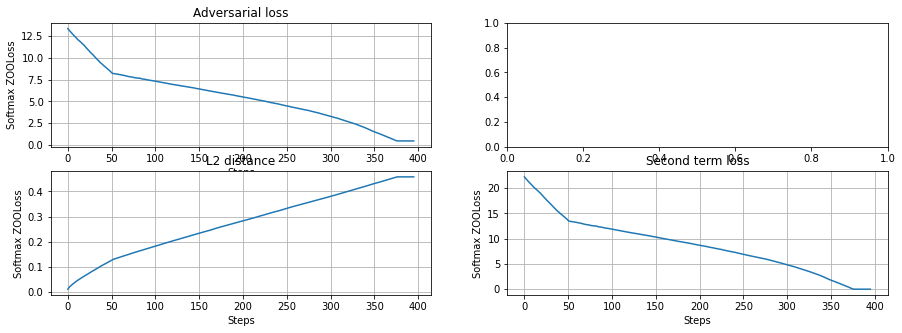

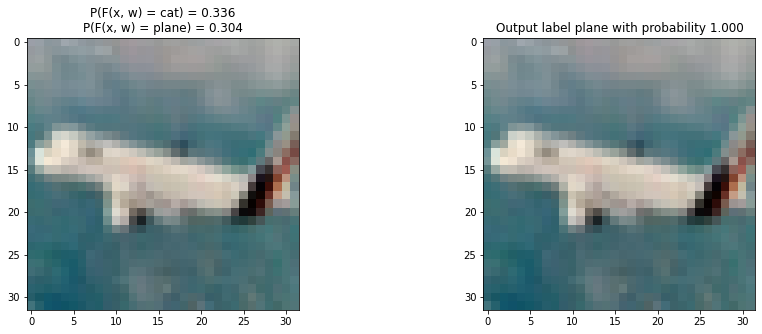

In [58]:
### Define our custom loss function and call the optimizer
adv_loss = customLoss.ZooLoss(neuron=desired_output, maximise=1, is_softmax=False, dim=1)
adv_optimizer = ZOOptim.ZOOptim(model=net, loss=adv_loss, device='cuda')

### Run the optimizer
x, loss, l2_dist, losses_st, outs = adv_optimizer.run(params)

### Compute manually last output
out = nn.Softmax(dim=1)(net(x.reshape(1, *list(img.shape))))
label = torch.argmax(out).item()
img = x.detach().cpu().numpy()

### Display results
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
# Adversarial Loss
ax[0,0].plot(loss)
ax[0,0].set_title('Adversarial loss')
ax[0,0].set_ylabel('Adversarial loss')
ax[0,0].set_xlabel('Steps')
ax[0,0].grid()
# L2 distance
ax[1,0].plot(l2_dist)
ax[1,0].set_title('L2 distance')
ax[1,0].set_ylabel('L2_dist')
ax[1,0].set_xlabel('Steps')
ax[1,0].grid()
# Second loss term
ax[1,1].plot(losses_st)
ax[1,1].set_title('Second term loss')
ax[1,1].set_ylabel('Softmax ZOOLoss')
ax[1,1].set_xlabel('Steps')
ax[1,1].grid()
plt.show

### Display adversarial example and original image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Adversarial example
ax[0].imshow(np.transpose(img_orig, (1, 2, 0)))
ax[0].set_title('P(F(x, w) = {}) = {:.3f}\nP(F(x, w) = {}) = {:.3f}'.format(DataLoader.classes[label], 
                                                                            float(out[0, label]),
                                                                            DataLoader.classes[original_label], 
                                                                            float(out[0, original_label])))
# Original image
ax[1].imshow(np.transpose(img_orig, (1, 2, 0)))
original_label = torch.argmax(out_orig)
ax[1].set_title('Output label {} with probability {:.3f}'.format(DataLoader.classes[original_label], 
                                                                 float(out_orig[0, original_label])))
plt.show()